# HW2- Salil Rabade
Analysing a time series data using a LSTM type Recurrent Neural Network.In this Homework we explore if RNN can be used to stock price predictions , in this case Apple. 

In [12]:
from keras.models import Sequential,load_model
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Activation, Flatten ,Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from scipy import signal
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras import backend as K
import timeit
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
import argparse
import os
from sklearn.preprocessing import MinMaxScaler
import mlflow.keras


### Import Dataset
The Apple stock price dataset is taken from investing.com and can be found here. To train the LSTM, 4 years of data is used and this is used to predict the Apple stock price from 8thFeb to 6th March 2020. In setting up the LSTM model, the timestep serves as the feature while the current/future price serves as the label.

(1228, 1)
(31, 7)
(1228, 7)


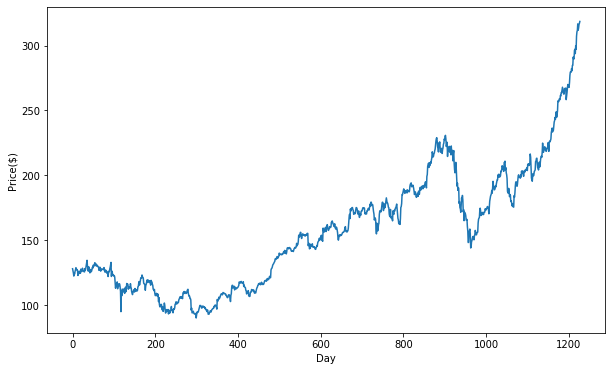

In [147]:

path=os.getcwd()
apple_training = pd.read_csv(r'AAPL.csv')
apple_test=pd.read_csv(r'AAPL_Test.csv')
google_test_processed=google_test.iloc[:, 1:2].values
apple_training_processed = apple_training.iloc[:, 1:2].values
apple_test_processed = apple_test.iloc[:, 1:2].values
scaler = MinMaxScaler(feature_range = (0, 1))
apple_training_scaled = scaler.fit_transform(apple_training_processed)
plt.figure(figsize=(10,6))
plt.plot(apple_training_processed)
plt.xlabel('Day')
plt.ylabel('Price($)')
print(apple_training_scaled.shape)


apple_total = pd.concat((apple_training_complete['Open'], apple_test_complete['Open']), axis=0)
# apple_total= apple_total.iloc[:, 1:4]
print(apple_test_complete.shape)
print(apple_training_complete.shape)

 

## Preprocessing Data  and Simple LSTM

LSTM's require input data in a 3d Tensor format (#egs. X #timesteps X #Features).In this cell we define a function to define the simplest LSTM. The simple LSTM consists of one LSTM layer followed by a dense layer to give a scalar output.
The model is run with different timesteps parameter : 1,30 and 60. 

In [71]:
def LSTM1(TS):
    features = []
    labels = []
    test_inputs = apple_total[len(apple_total) - len(apple_test_complete) - TS:].values
    test_inputs = test_inputs.reshape(-1,1)
    print(test_inputs.shape)
    test_inputs = scaler.transform(test_inputs)

    test_features = []
    for i in range(TS, TS+30):
        test_features.append(test_inputs[i-TS:i, 0])
    

    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))   
    #TS=60
    
    for i in range(TS, 1228):
        features.append(apple_training_scaled[i-TS:i, 0]) # The past data are the 'features'
        labels.append(apple_training_scaled[i, 0]) # The future data are the 'labels'
    
    features, labels = np.array(features), np.array(labels)
    print(features.shape)
    features = np.reshape(features, (features.shape[0], features.shape[1], 1))
    #print(features[0::60,1])
    print(labels)
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(features.shape[1], 1)))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    model.summary()
    # Predict and save Model
    model.fit(features, labels, epochs = 50, batch_size = 64)
    predictions = model.predict(test_features)
    print("Output shape is",predictions.shape)
    predictions = scaler.inverse_transform(predictions)
    model.save("model"+"TS"+str(TS))

    return predictions
    
    
    
    

## Deep LSTM
In this case an extra layer of LSTM is added. 

In [115]:
# Model 2
def LSTM2(TS):
    features = []
    labels = []
    test_inputs = apple_total[len(apple_total) - len(apple_test_complete) - TS:].values
    test_inputs = test_inputs.reshape(-1,1)
    print(test_inputs.shape)
    test_inputs = scaler.transform(test_inputs)

    test_features = []
    for i in range(TS, TS+30):
        test_features.append(test_inputs[i-TS:i, 0])
    

    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))   
    #TS=60
    
    for i in range(TS, 1228):
        features.append(apple_training_scaled[i-TS:i, 0]) # The past data are the 'features'
        labels.append(apple_training_scaled[i, 0]) # The future data are the 'labels'
    
    features, labels = np.array(features), np.array(labels)
    print(features.shape)
    features = np.reshape(features, (features.shape[0], features.shape[1], 1))
    #print(features[0::60,1])
    print(labels)
    model = Sequential()
    model.add(LSTM(units=50,return_sequences=True,input_shape=(features.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units = 1))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    model.summary()
    
    # Predict and save Model
    model.fit(features, labels, epochs = 50, batch_size = 64)
    predictions = model.predict(test_features)
    print("Output shape is",predictions.shape)
    predictions = scaler.inverse_transform(predictions)
    model.save("model"+"TS"+str(TS))

    return predictions


## Deep LSTM with dropout
Dropout usually is used to counteract overfitting. In this network, the same LSTM is used with dropout (p=0.2).

In [121]:
# Model 3
def LSTM3(TS):
    features = []
    labels = []
    test_inputs = apple_total[len(apple_total) - len(apple_test_complete) - TS:].values
    test_inputs = test_inputs.reshape(-1,1)
    print(test_inputs.shape)
    test_inputs = scaler.transform(test_inputs)

    test_features = []
    for i in range(TS, TS+30):
        test_features.append(test_inputs[i-TS:i, 0])
    

    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))   
    #TS=60
    
    for i in range(TS, 1228):
        features.append(apple_training_scaled[i-TS:i, 0]) # The past data are the 'features'
        labels.append(apple_training_scaled[i, 0]) # The future data are the 'labels'
    
    features, labels = np.array(features), np.array(labels)
    print(features.shape)
    features = np.reshape(features, (features.shape[0], features.shape[1], 1))
    #print(features[0::60,1])
    print(labels)
    model = Sequential()
    model.add(LSTM(units=50,return_sequences=True,input_shape=(features.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    model.summary()
    
    # Predict and save Model
    model.fit(features, labels, epochs = 50, batch_size = 64)
    predictions = model.predict(test_features)
    print("Output shape is",predictions.shape)
    predictions = scaler.inverse_transform(predictions)
    model.save("model3"+"TS"+str(TS))

    return predictions


## Hyperparamater tuning

In [123]:
TS_Predict=[]
TS_Predict2=[]
TS_Predict3=[]
Step=[1,30,60]
for j in Step:
    Predict= LSTM1(j)
    Predict2=LSTM2(j)
    Predict3=LSTM3(j)
    TS_Predict.append(Predict[:,0])
    TS_Predict2.append(Predict2[:,0])
    TS_Predict3.append(Predict3[:,0])
    

    
TS_Predict=np.array(TS_Predict)
TS_Predict=TS_Predict.T # Transpose
TS_Predict2=np.array(TS_Predict2)
TS_Predict2=TS_Predict2.T # Transpose
TS_Predict3=np.array(TS_Predict3)
TS_Predict3=TS_Predict3.T # Transpose
print(TS_Predict.shape)

(32, 1)
(1227, 1)
[0.1592878  0.15202556 0.14135095 ... 0.98989414 0.99391904 1.        ]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1227/1227 [==============================] - 10s 8ms/step - loss: 0.1041
Epoch 2/50
1227/1227 [==============================] - 0s 65us/step - loss: 0.0623
Epoch 3/50
1227/1227 [==============================] - 0s 81us/step - loss: 0.0362
Epoch 4/50
1227/1227 [==============================] - 0s 94us/step - loss: 0.0247
Epoch 5/50
1227/1227 [==============================] - 0s 91us/step - loss: 0.0209
Epoch 6/50
1227/1227 [==

Text(0, 0.5, 'Price($)')

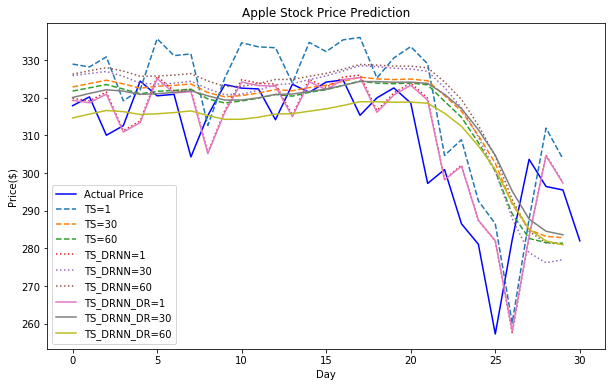

In [125]:

    plt.figure(figsize=(10,6))
    plt.plot(apple_test_processed, color='blue')
    plt.plot(TS_Predict,linestyle='dashed')
    plt.plot(TS_Predict2,linestyle='dotted')
    plt.plot(TS_Predict3,linestyle='solid')
    plt.legend(['Actual Price','TS=1','TS=30','TS=60','TS_DRNN=1','TS_DRNN=30','TS_DRNN=60','TS_DRNN_DR=1','TS_DRNN_DR=30','TS_DRNN_DR=60'])
    plt.title('Apple Stock Price Prediction')
    plt.xlabel('Day')
    plt.ylabel('Price($)')

## Inference
From the LSTM's we can infer the following
1 : Using a smaller timestep seems to provide an 'offset model'. This curve though does not appear smooth. A larger timestep reduces the elementwise error.
2 : Using a deeper network smoothens out the curve
3 : Dropout reduces overfitting and further reduces elementwise error.

This is also reflected in the RMSE error. Deeper dropout layer network seems to reduce root mean square error. It should be noted that the square error is not scaled and is plotted in the raw format.
In this study the effect of epoch, and no.of units in LSTM was not studied as that was pretty well understood from HW-1. The lierature suggests a similar trend is expected for LSTM's as well.


Text(0, 0.5, 'Error')

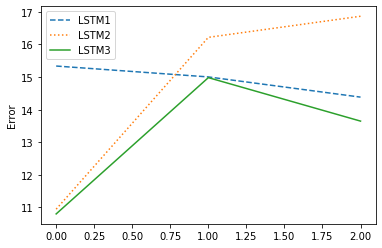

In [145]:
## RMSE Error
M1=np.zeros(3)
M2=np.zeros(3)
M3=np.zeros(3)
for k in range (0,3):
    M1[k]=np.sqrt(np.square(np.subtract(apple_test_processed[0:30,0],TS_Predict[:,k])).mean())
    M2[k]=np.sqrt(np.square(np.subtract(apple_test_processed[0:30,0],TS_Predict2[:,k])).mean())
    M3[k]=np.sqrt(np.square(np.subtract(apple_test_processed[0:30,0],TS_Predict3[:,k])).mean())

plt.plot(M1,linestyle='dashed')
plt.plot(M2,linestyle='dotted')
plt.plot(M3,linestyle='solid')
plt.legend(['LSTM1','LSTM2','LSTM3'])
plt.ylabel('Error')
    

## Reference
[https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/](url_here)
